In [25]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 235 µs (started: 2023-02-28 11:08:45 -05:00)


Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt  # required for plotting

from functools import partial

from braket.ahs.atom_arrangement import AtomArrangement

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from braket.aws import AwsDevice 
from collections import Counter

from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import pdist

import pickle
import networkx as nx
import os


time: 473 µs (started: 2023-02-28 11:08:45 -05:00)


In [27]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

time: 1.41 ms (started: 2023-02-28 11:08:45 -05:00)


In [28]:
from utils import *

time: 145 µs (started: 2023-02-28 11:08:45 -05:00)


In [29]:
#@title Define the graph

a = 5.3e-6  # nearest-neighbor separation (in meters)

# Define coordiantes of the atoms in the graph A
# as a numpy array of shape (N, 2), where N is the number of nodes
graphA_nodes = np.array([[0., 0.],[0., 1.], [np.sqrt(3)/2, 0.5], [np.sqrt(3)/2 + 1., 0.5], 
                          [np.sqrt(3) + 1., 0.], [np.sqrt(3) + 1., 1.]])
graphB_nodes = np.array([[0., 0.],[0., 1.], [1., 0.], [1, 1], 
                          [2., 0.], [2., 1.]])                          
graphs_nodes = [graphA_nodes, graphB_nodes] 

time: 473 µs (started: 2023-02-28 11:08:45 -05:00)


In [30]:
# graphs = pickle.load(open('Datasets/PTC_graphs_max_12_nodes.p', 'rb'))
# graphs_pos = [nx.spring_layout(graph, k=1.5) for graph in graphs]
# graphs_nodes = [np.array([list(pos) for pos in graph_pos.values()]) for graph_pos in graphs_pos]
# min_dist = [np.min(pdist(graph_nodes)) for graph_nodes in graphs_nodes]
# graphs_pos = [nx.spring_layout(graph, k=1, scale=1/min_d) for min_d, graph in zip(min_dist, graphs)]
# graphs_nodes = [np.array([list(pos) for pos in graph_pos.values()]) for graph_pos in graphs_pos]

time: 248 µs (started: 2023-02-28 11:08:45 -05:00)


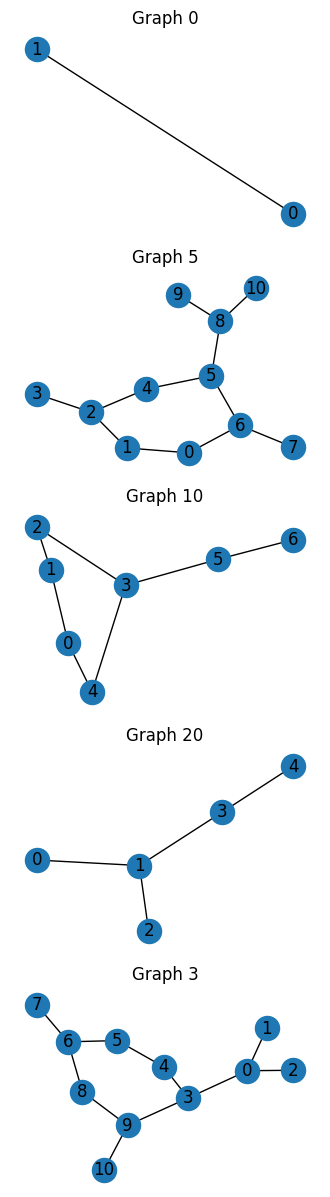

time: 232 ms (started: 2023-02-28 11:08:45 -05:00)


In [31]:
#@title Plot graphs 
idices = [0, 5, 10, 20, 3]
fig, axs = plt.subplots(len(idices), 1, figsize=(4, 3 * len(idices)))        
plot_graphs(axs, idices, graphs)        

In [32]:
def get_register(graph_nodes):
    register = AtomArrangement()
    for node in graph_nodes:
        register.add(node * a)
    return register

time: 220 µs (started: 2023-02-28 11:08:46 -05:00)


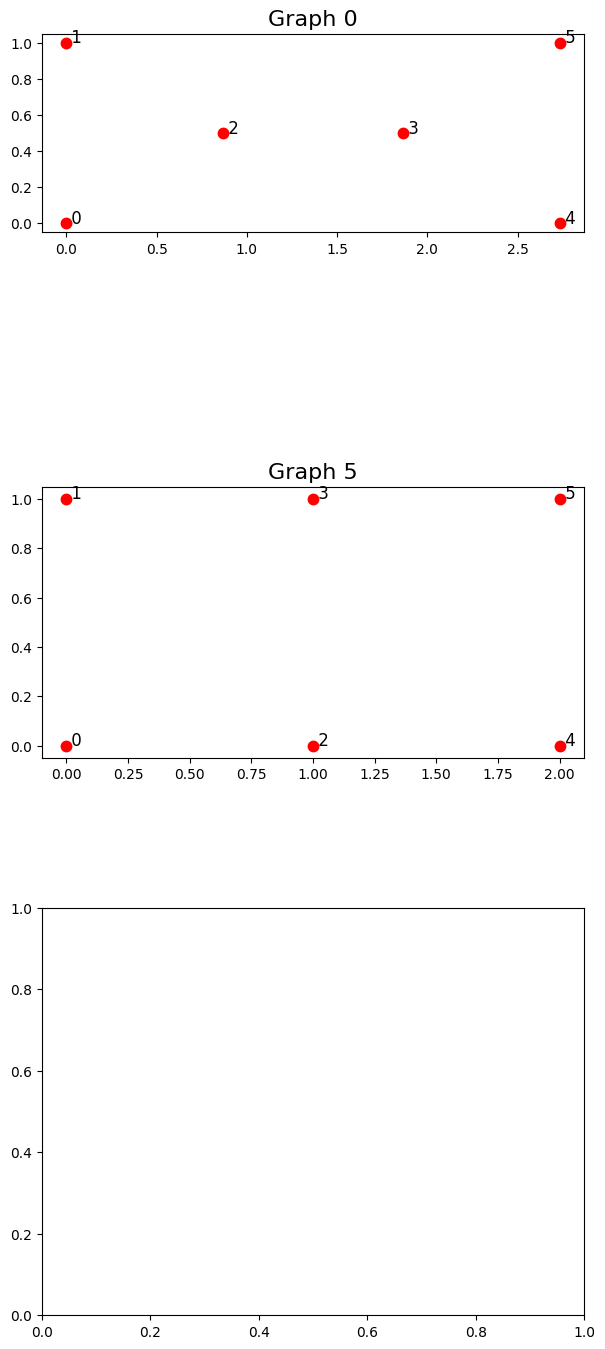

time: 188 ms (started: 2023-02-28 11:08:46 -05:00)


In [33]:
idices = [0, 5, 10, 20, 3]
labels = idices
fig, axes = plt.subplots(3, 1, figsize=(7,6 * 3))
for i, (ax, graph_nodes) in enumerate(zip(axes, graphs_nodes)):
    # register = get_register(graph_nodes)
    xs, ys = (graph_nodes[:, 0], graph_nodes[:, 1])
    ax.plot(xs, ys, 'r.', ms=15)
    for idx, (x, y) in enumerate(zip(xs, ys)):
        ax.text(x, y, f" {idx}", fontsize=12)
    ax.set_aspect('equal')    
    ax.set_title(f"Graph {labels[i]}", fontsize=16)
# plt.show()  # this will show the plot below in an ipython or jupyter session

In [34]:
# can also use the register to plot the graph to double check

# fig, axes = plt.subplots(2, 1, figsize=(10,6))
# for ax, graph_nodes in zip(axes, graphs_nodes):
#     register = get_register(graph_nodes)
#     xs, ys = [register.coordinate_list(dim) for dim in (0, 1)]
#     ax.plot(xs, ys, 'r.', ms=15)
#     for idx, (x, y) in enumerate(zip(xs, ys)):
#         ax.text(x, y, f" {idx}", fontsize=12)
#     ax.set_aspect('equal')    
#     plt.suptitle("Graph A", fontsize=16)
# # plt.show()  # this will show the plot below in an ipython or jupyter session

time: 228 µs (started: 2023-02-28 11:08:46 -05:00)


In [35]:
#@title Define parameters of the simulation
def get_drive(time_max=4e-6):
    """AnalogHamiltonianSimulation requires a DrivingField object as input.
    This function returns a DrivingField object that represents the driving 
    used in https://arxiv.org/pdf/2211.16337.pdf

    Args:
        time_max (float): The maximum time (in seconds) of the driving field. 
        The driving field is defined for 0 <= t <= time_max.
    
    Returns:
        DrivingField: The driving field
    """
    # smooth transition from "down" to "up" state
    # time_max = 4e-6  # seconds
    time_ramp = 1e-8  # seconds
    omega_max = 1e6  # rad / sec
    # omega_max = 6300000.0  # rad / sec
    # delta_start = -5 * omega_max
    # delta_end = 5 * omega_max
    delta_start = 0.7 * omega_max
    phi_start = 0.06 * omega_max
    delta_end = 0.7 * omega_max

    C6 = 5.42 * 1e-24 # C6 coefficient (in rad m^6 / s)
    # check Rydberg effective blockade radius
    R_6 = (C6 / np.sqrt(omega_max**2 + delta_start**2))**(1/6) # in meters
    # print(f"R_6 = {R_6 * 1e6} um and is equivalent to {R_6 / a} lattice spacings")
    # print(f"time could be {np.pi / (np.sqrt(2) * omega_max)}")

    omega = TimeSeries()
    omega.put(0.0, omega_max)
    omega.put(time_max, omega_max)    
    # omega.put(0.0, 0.0)
    # omega.put(time_ramp, omega_max)
    # omega.put(time_max - time_ramp, omega_max)
    # omega.put(time_max, 0.0)
    # omega.put(omega_max, omega_max)

    delta = TimeSeries()
    delta.put(0.0, delta_start)
    # delta.put(time_ramp, delta_start)
    # delta.put(time_max - time_ramp, delta_end)
    delta.put(time_max, delta_start)
    # delta.put(delta_start, delta_end)

    phi = TimeSeries().put(0.0, phi_start).put(time_max, phi_start)

    drive = DrivingField(
        amplitude=omega,
        phase=phi,
        detuning=delta
    )
    return drive 

time: 744 µs (started: 2023-02-28 11:08:46 -05:00)


In [36]:
drive = get_drive()

time: 183 µs (started: 2023-02-28 11:08:46 -05:00)


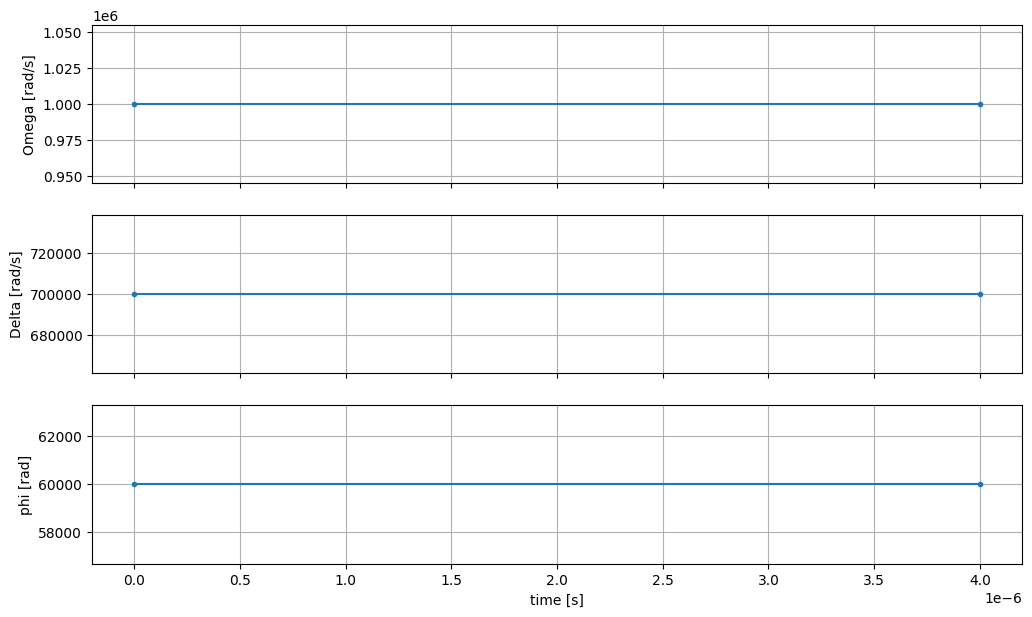

time: 149 ms (started: 2023-02-28 11:08:46 -05:00)


In [37]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
time_series = drive.amplitude.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Omega [rad/s]')

ax = axes[1]
time_series = drive.detuning.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Delta [rad/s]')

ax = axes[2]
time_series = drive.phase.time_series
# Note: time series of phase is understood as a piecewise constant function
ax.step(time_series.times(), time_series.values(), '.-', where='post');
ax.set_ylabel('phi [rad]')
ax.grid()
ax.set_xlabel('time [s]')

plt.show()  # this will show the plot below in an ipython or jupyter session


In [38]:

def run_simulation(device, register, drive, shots):
    """Run the simulation on the given device and return the results.
    
    Args:
        device (Device): The device to run the simulation on
        register (AtomArrangement): The register to run the simulation on
        drive (DrivingField): The driving field to use in the simulation
        shots (int): The number of shots to run the simulation for
    
    Returns:
        Counter: The results of the simulation
    """
    ahs_program = AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=drive
    )
    result_simulator = device.run(ahs_program, shots=shots).result()
    return result_simulator



def get_counts(result):
    """Aggregate state counts from AHS shot results

    A count of strings (of length = # of spins) are returned, where
    each character denotes the state of a spin (site):
       e: empty site
       u: up state spin
       d: down state spin

    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns
        dict: number of times each state configuration is measured

    """
    state_counts = Counter()
    states = ['e', '1', '0']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))
    return dict(state_counts)


     

time: 658 µs (started: 2023-02-28 11:08:46 -05:00)


In [39]:
shots = 1_0
# device = LocalSimulator("braket_ahs")
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
t_range = np.linspace(1e-7, 5.*1e-6, 5)
my_nodesB = [0]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    print(f"Running simulation for t_max = {t_max}")
    results_graphs = []
    for graph in graphs_nodes:
        register = get_register(graph) # get register with different graph
        drive = get_drive(t_max) # get drive with different duration
        result_simulator = run_simulation(device, register, drive, shots) # run simulation
        results_graphs.append(result_simulator)
    results.append(results_graphs)

Running simulation for t_max = 1e-07


ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: 1 validation error for AtomArrangementValidator
__root__
  Coordinates 2([Decimal('0.000004589934640057525'), Decimal('0.00000265')]) is defined with too high precision; they must be multiples of 1E-7 meters (type=value_error)

time: 1.52 s (started: 2023-02-28 11:08:46 -05:00)


In [ ]:
filename = 'results_aws_6k_100t_12nodes_all.p'
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))

# pickle.dump(results, open(filename, 'wb'))

time: 6.38 s (started: 2023-02-27 23:32:08 -05:00)


In [ ]:
# new_results = pickle.load(open("results_QEK/"+filename, 'rb'))
# counts_graph = [get_counts(result_graph) for result_graph in results[0]] # get state counts from simulator result
# print(counts_graph[0])

{'000000': 5181, '000001': 146, '000010': 129, '000100': 123, '001000': 136, '001001': 4, '001010': 3, '010000': 128, '010001': 3, '010010': 2, '010100': 5, '100000': 131, '100001': 1, '100010': 3, '100100': 5}
time: 6.56 s (started: 2023-02-27 23:33:06 -05:00)


In [ ]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, results_graph in zip(t_range, results): # loop over different drive durations
    counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

Text(0, 0.5, 'kernel FS')

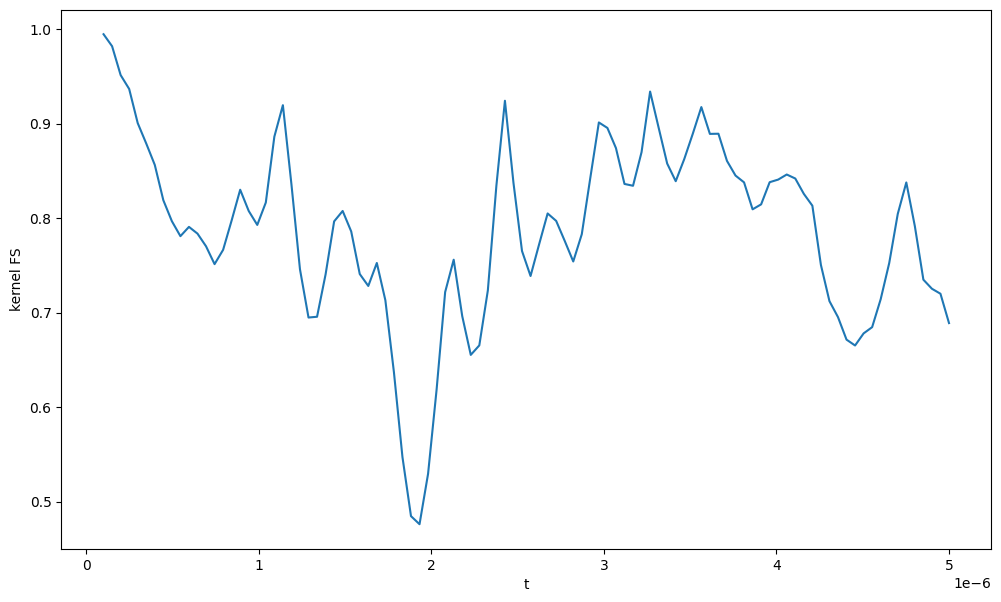

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, kernels[:, 0, 1], label='kernel')
axes.set_xlabel('t')
axes.set_ylabel('kernel FS')

Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

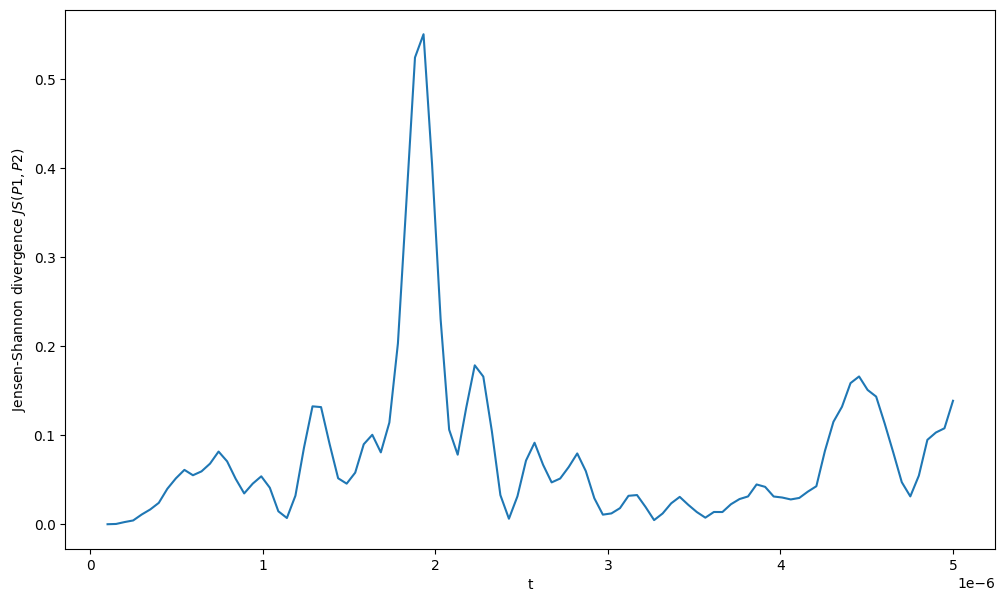

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [ ]:
np.argmin((- np.log(kernels[34:50, 0, 1]))**2)

13

In [ ]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, results_graph in zip(t_range, results): # loop over different drive durations
    counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

Text(0.5, 0, 'Drive duration [s]')

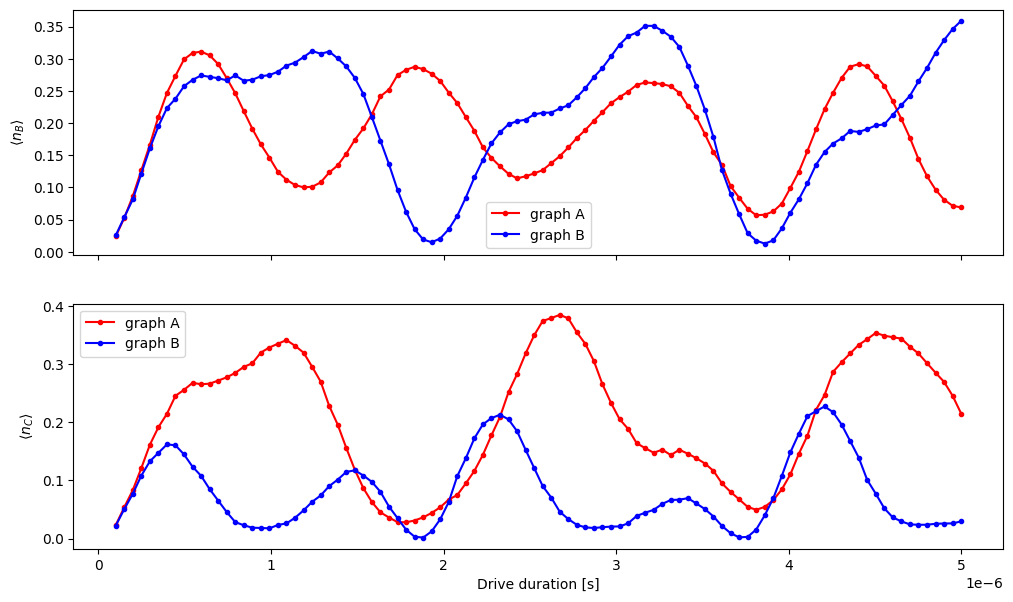

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

In [ ]:
t_range[39]

2.03030303030303e-06

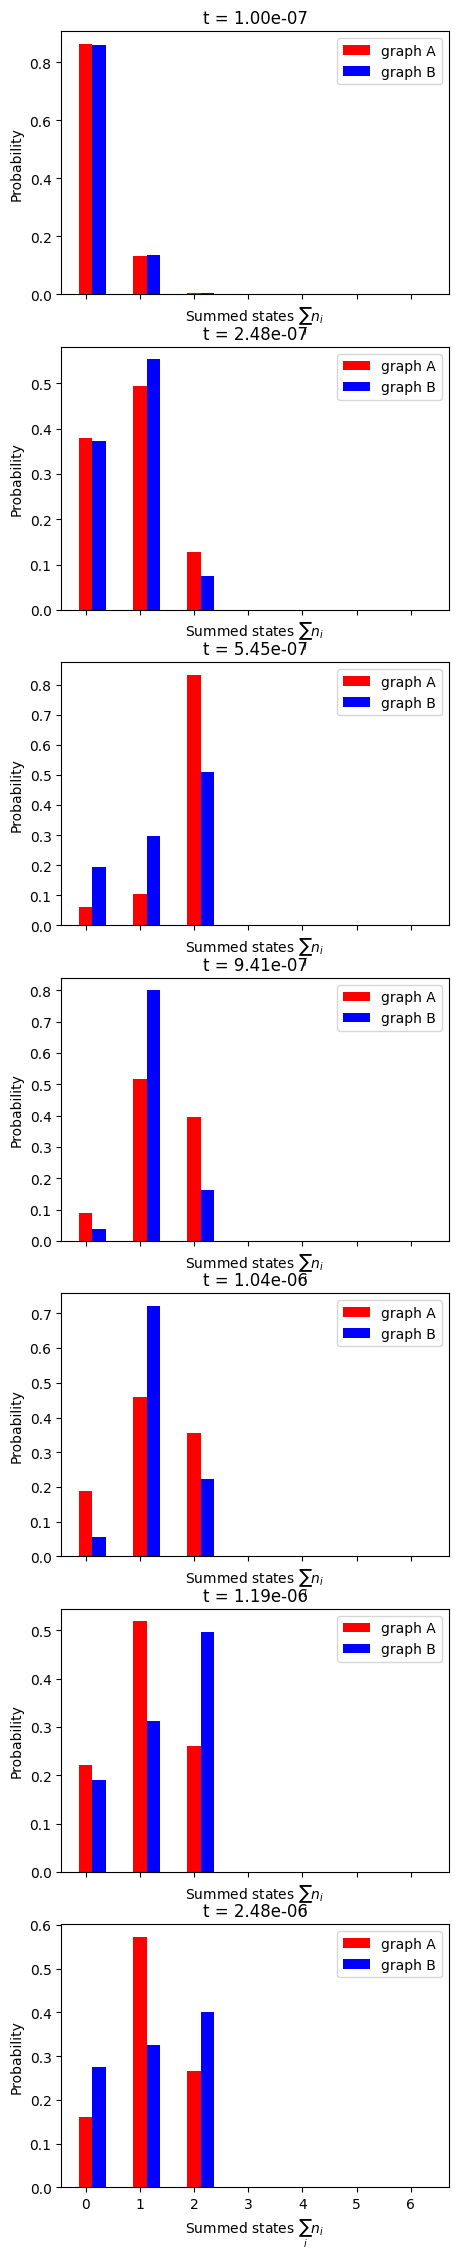

In [ ]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 2.5e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = get_counts(results[idx][i]) 
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))




#### look at correlation function

In [ ]:
counts_simulator = get_counts(result_simulator)  # takes about 5 seconds
print(counts_simulator)

{'000000': 652, '000001': 333, '000010': 336, '000100': 179, '000101': 1, '000110': 2, '001000': 167, '001001': 1, '010000': 360, '010001': 1204, '010010': 585, '011000': 1, '100000': 350, '100001': 554, '100010': 1271, '100100': 4}


In [ ]:
def get_density_correlation_Z2(result):
    post_sequences = np.array([list(measurement.post_sequence) for measurement in result.measurements])
    return np.cov(post_sequences.T)

gij = get_density_correlation_Z2(result_simulator)

We see a disjoint deparation in this graph!

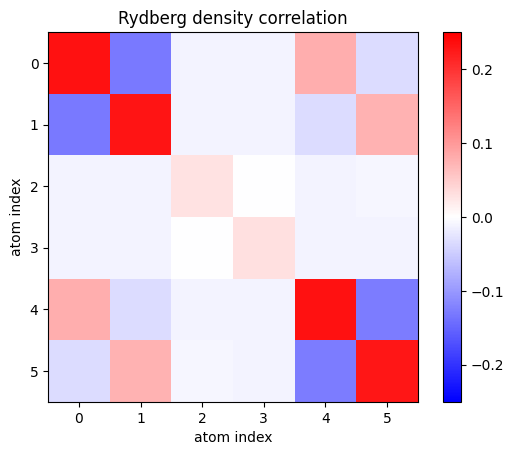

In [ ]:
plt.imshow(gij, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(len(graphA_nodes)), [f'{i}' for i in range(len(graphA_nodes))])
plt.xlabel("atom index")
plt.yticks(range(len(graphA_nodes)), [f'{j}' for j in range(len(graphA_nodes))])
plt.ylabel("atom index")
plt.title('Rydberg density correlation')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()